# Calculate permeability from well log data

This notebook can be used to calculate porosity, clay content, mean and standard devation of grain size and permeability using well density log and neutron log data. 

Porosity is calculated using density log data and densities of the fluid and solid matrix specified below. Clay content is calculated using the difference between neutron log porosity and porosity calculated using the density log. Grain size distribution is calculated using an empirical relation between clay content and grain size of the non-clay fraction of the sediments. Permeability is calculated following the equations detailed in the [calculate_permeability_sediment_mixtures.ipynb](calculate_permeability_sediment_mixtures.ipynb) notebook.

Note that estimating the clay content using the difference between neutron and density logs is a more accurate method than using gamma ray logs to calculate clay content. Gamma rays are often a good indicator of clays but this relation does not always hold up, as shown in the lack of gamma ray response in the example dataset and discussed in detail [here](https://sp.lyellcollection.org/content/48/1/27.short).

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as pl
import matplotlib.gridspec

## file containing well log data:

Change the filename to analyze your own well log file. Make sure the columns have the same headers as the example file.

In [2]:
fn = 'data/well_logs_AST02.csv'

## File with porsity & permeability data samples

This is onl used for the figure, leave the file empty (except the header row) if you do not have any data to compare with

In [3]:
fnp = 'data/porperm_data_well_AST02.csv'

## Some parameters

In [4]:
# depth interval to show in figure
ymin, ymax = 1495, 1540

# density fluids
RHOF = 1025.0

# avg. density solid matrix:
RHOMA = 2650.0

# min max grain density from porperm data AST-02
#RHOMA_min = 2600.0
#RHOMA_max = 2690.0

# emprical constants permeability eq. for clays:
clays = ['kaolinite', 'illite', 'smectite']
k0_clays = 10 ** np.array([-16.21014136, -18.81362945, -20.92831503])
m_clays = np.array([3.60952787, 3.57637639, 3.01368043])

# estimate for clay fractions well AST-02
clay_fractions_avgs = np.array([0.15, 0.50, 0.35])

# percolation threshold for the Kozeny-Carman 
phi_threshold = 0.025

# Kozeny Carman constant
C = 5.0
rho_s = 2650.0
rho_w = 1025.0

# hydrogen index clays:
HI = 0.388

# correction of depth of different logs:
depth_corr = 2.0

# power mean exponent. 
# This governs if the permeability of the sediment mixture is calculated as the harmonic mean, geometric mean or arithmetic mean, 
# or something in between. Use p=-1 for harmonic mean, p=0 for geometric mean or p=1 for arithmetic mean
# Luijendijk and Gleeson (2015) suggest that p=0 would be the best value for first order estiamtes of permeability vairation
# however this has only been tested on a relatively small dataset, and it may be dependent on the type and size of samples, internal structure of samples,
# depositional environments etc...
power_mean_exponent = 0.0

# type of figure to save. you can choose png, svg, pdf, jpg etc.. see matplotlib savefig documentation for more info
figure_extension = 'png'

## read datafiles:

In [5]:
cl = pd.read_csv(fn)
porperm = pd.read_csv(fnp)

## Calculate porosity from density log data

In [6]:
# calculate porosity from density log
cl['DPHI'] = (RHOMA - cl['RHOB'] * 1000.0) / (RHOMA - RHOF)

## clay content using the difference between neutron log and density logs

In [7]:
# correct NPHI for limestone vs sand:
cl['NPHI_ss'] = cl['NPHI'] / 100.0 + 0.04

# calculate difference neutron and density logs
cl['NDPHI_diff'] = cl['NPHI_ss'] - cl['DPHI']

cl['clay_fraction_NDPHI'] = cl['NDPHI_diff'] / HI
cl['clay_fraction_NDPHI'][cl['clay_fraction_NDPHI'] < 0.0] = 0.0

## calculate the permeabiltiy of the clay fraction using estimates of clay mineralogy

In [8]:
def calculate_k_clay_exponential(porosity, k0, m):
    
    """
    calculate permeability as an exponential function of void ratio 
    """
    
    void_ratio = porosity / (1.0 - porosity)
    
    return k0 * void_ratio**m

for clay, k0_clay, m_clay in zip(clays, k0_clays, m_clays):
    cl['k_%s' % clay] = calculate_k_clay_exponential(cl['DPHI'], k0_clay, m_clay)

cl['k_clay_best'] = 0
for clay, clay_fraction_avg in zip(clays, clay_fractions_avgs):
    cl['k_clay_best'] += clay_fraction_avg * np.log10(cl['k_%s' % clay])
cl['k_clay_best'] = 10 ** cl['k_clay_best']


## Empirical estimate of grain size distribution parameters

The mean and standard deviation of the log-transformed grain size dsitribution are estimated using an empricial regression of grain size vs clay content publsihed in Luijendijk & Gleeson (2015). While in general this correlation should hold for most sediments (ie. higher clay contents, the lower the grain size of the non-clay fraction), the regression parameters are likely to vary between different sediment formations.

In [9]:
cl['log_mean_gs'] = -2.89787583403718 * cl['clay_fraction_NDPHI'] - 4.23309622704539
cl['log_std_gs'] = 2.57433961201677 * cl['clay_fraction_NDPHI'] + 1.17738921132606

## Calculate specific surface using grain size distribution parameters 

In [10]:
def calculate_specific_surface_discrete(grain_size, freq, rho_s):
    
    """
    calculate specific surface
    eq. ... in 
    """
    
    Sa = 6.0 / rho_s * (freq / grain_size).sum()
    
    return Sa


def calculate_specific_surface_granular_fraction(log10_gs_mean, log10_gs_std,
                                                 rho_s=2650.0):
    """
    calculate specific surface for granular fraction (ie. > 2 um)
    input: grainsize distribution, mean log10(grainsize), std log10(grainsize)

    """
    
    # grain size bins
    log_gs_sim = np.arange(-7.0, -1, 0.01)
    
    # calculate cdf
    cdf_gs = scipy.stats.norm.cdf(log_gs_sim, log10_gs_mean, log10_gs_std)
    
    # convert to frequency for each bin
    freq_gs = cdf_gs.copy()
    freq_gs[1:] = (cdf_gs[1:] - cdf_gs[:-1])
    
    # convert grainsize to real units
    bins_gs = (10**log_gs_sim).copy()

    # take middle of bin
    bins_gs[1:] = (bins_gs[1:] + bins_gs[:-1]) / 2.0
    
    # remove clay fraction
    freq_gs[bins_gs < 2e-6] = 0
    
    # calculate specific surface
    rho_s = 2650.0
    Ss_granular = calculate_specific_surface_discrete(bins_gs, freq_gs, rho_s)

    return Ss_granular

In [11]:
# estimate specific surface granular fraction
cl['Ss_granular'] = np.nan
for i in cl.index:
    cl.loc[i, 'Ss_granular'] = calculate_specific_surface_granular_fraction(
        cl.loc[i, 'log_mean_gs'], cl.loc[i, 'log_std_gs'])

/Users/elcopone/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/elcopone/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/elcopone/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


## Calculate permeability granular (sand, silt) fraction using Kozeny-Carman eq.:

In [12]:
def kozeny_carman_percolation_threshold(phi, C, Sa, rho_s, rho_w,
                                        phi_threshold):
    
    phi_eff = phi - phi_threshold
    rho = phi * rho_w + (1.0 - phi) * rho_s
    
    Sa_vol = Sa * (1.0 - phi) * rho_s
    
    k = (1.0 / (C * Sa_vol**2)) * phi_eff**3 / (1.0 - phi_eff)**2
    
    return k

cl['k_granular_best'] = kozeny_carman_percolation_threshold(
    cl['DPHI'], C, cl['Ss_granular'], rho_s, rho_w, phi_threshold)


## Calculate the overall permeability

In [13]:
def power_mean(p, w, k1, k2):

    """
    calculate power mean of two components
    reduces to arithmetic mean for p=1 and harmonic mean for p=-1
    returns the geomteric mean for p=0

    """
    
    if p!=0:
        k_calc = (w*k1**p + (1-w)*k2**p)**(1.0/p)
    
    elif p == 0:
        k_calc = np.exp(w*np.log(k1) + (1-w)*np.log(k2))
        
    # find pure clay samples
    ind_sand = w == 0
    k_calc[ind_sand] = k2
    
    # find pure sand samples
    ind_clay = w == 1.0
    k_calc[ind_clay] = k1
    
    return k_calc

cl['power_mean_exponent'] = power_mean_exponent
cl['k_calculated'] = power_mean(power_mean_exponent, cl['clay_fraction_NDPHI'], 
                                    cl['k_clay_best'], cl['k_granular_best'])

## Save results to a new .csv file:

In [14]:
fno = fn[:-4] + '_with_calculated_k.csv'
cl.to_csv(fno)
print('saved csv file with calculated permeability as %s' % fno)

saved csv file with calculated permeability as data/well_logs_AST02_with_calculated_k.csv


## Show the results in a figure:

saving figure as  figs/well_logs_AST02_with_calculated_k.png


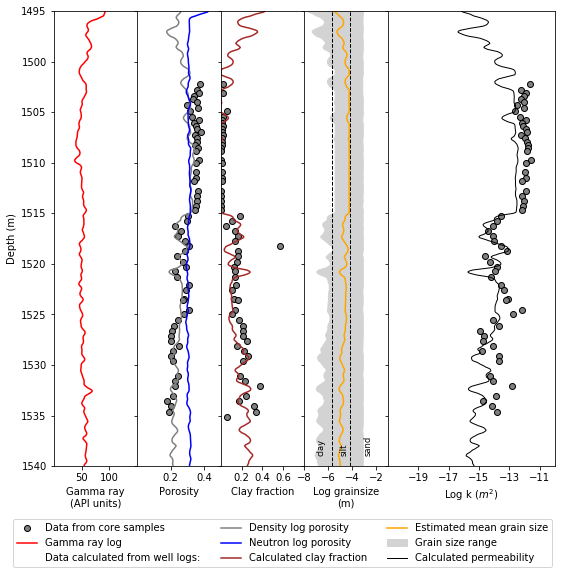

In [15]:
fig = pl.figure(figsize=(8, 8))

nrows = 1
ncols = 5
width_ratios = [5, 5, 5, 5, 10]

gs = matplotlib.gridspec.GridSpec(nrows, ncols, width_ratios=width_ratios)

bottom = 0.18
gs.update(wspace=0.0, hspace=0.02,
          bottom=bottom, top=0.97, right=0.97, left=0.1)

ax = []
for col in range(ncols):
    ax.append(fig.add_subplot(gs[0, col]))
    
ax_GR, ax_phi, ax_clay, ax_gs, ax_k = ax

# Gamma ray panel:
leg_GR, = ax_GR.plot(cl['GR'], cl['depth'] + depth_corr, color='red')
ax_GR.set_xlim(0, 150.0)
#ax_GR.set_xlim(320.,400)
ax_GR.set_xticks([50.0, 100.0])
ax_GR.set_xlabel('Gamma ray\n(API units)')

# porosity:
leg_phi_core = ax_phi.scatter(porperm['porosity'], porperm['depth'],
                              facecolor='gray', edgecolor='black')
ax_phi.set_xticks([0.2, 0.4])
ax_phi.set_xlim(0.0, 0.5)
ax_phi.set_xlabel('Porosity')
empty_line = ax_phi.axhline(porperm['porosity'].mean(), visible=False)

# grain size data
leg_clay_core = ax_clay.scatter(porperm['clay_fraction'], porperm['depth'],
                                facecolor='gray', edgecolor='black')

leg_k_core = ax_k.scatter(np.log10(porperm['permeability_measured']), porperm['depth'],
                          facecolor='gray', edgecolor='black', zorder=1)

# panel 3: porosity
leg_DPHI, = ax_phi.plot(cl['DPHI'], cl['depth'] + depth_corr, color='gray', lw=1.5)
leg_NPHI, = ax_phi.plot(cl['NPHI_ss'], cl['depth'] + depth_corr, color='blue', lw=1.5)

# panel 4: clay content
leg_clay_sim, = ax_clay.plot(cl['clay_fraction_NDPHI'],
                             cl['depth'] + depth_corr,
                             color='brown', ls='-', lw=1.5)

#
ind = (cl['log_std_gs'].notnull())
x = np.concatenate(((cl['log_mean_gs'][ind] - cl['log_std_gs'][ind]),
                    (cl['log_mean_gs'][ind] + cl['log_std_gs'][ind])))
y = np.concatenate((cl['depth'][ind] + depth_corr,
                    cl['depth'][ind][::-1] + depth_corr))
leg_gs_sim_range, = ax_gs.fill(x, y, color='lightgrey', zorder=0)

#leg_gs_litho, = ax_gs.plot((np.log10(litho['M63']*1e-6),
#                            np.log10(litho['M63']*1e-6)),
#                            (litho['depth_top'], litho['depth_bottom']),
#                            color='orange', lw=1.5 )
leg_gs_sim, = ax_gs.plot(cl['log_mean_gs'],
                         cl['depth'] + depth_corr, color='orange')

leg_k_geom, = ax_k.plot(np.log10(cl['k_calculated']), cl['depth'] + depth_corr,
                        color='black', lw=1.0)

ax_GR.set_ylabel('Depth (m)')

ax_clay.set_xlabel('Clay fraction')
ax_clay.set_xticks([0.2, 0.4, 0.6])
ax_clay.set_xlim(0, 0.8)

ax_k.set_xlabel(r'Log k ($m^{2}$)')
ax_k.set_xticks([-19, -17, -15, -13, -11])
ax_k.set_xlim(-21, -10)

# set depth limits:
for ax_k in ax:
    ax_k.set_ylim(ymax, ymin)

for ax_k in ax[1:]:
    ax_k.set_yticklabels([])

ax_gs.set_xlim(-8, -1)
ax_gs.set_xticks([-8, -6, -4, -2])
ax_gs.set_xlabel('Log grainsize\n(m)')

ax_gs.axvline(np.log10(2e-6), ls='--', color='black', lw=1.0)
ax_gs.axvline(np.log10(63e-6), ls='--', color='black', lw=1.0)

ax_gs.text(-7, ymax - 1, 'clay',
           fontsize='small', rotation='vertical', va='bottom')
ax_gs.text(-5.0, ymax - 1, 'silt',
           fontsize='small', rotation='vertical', va='bottom')
ax_gs.text(-3.0, ymax - 1, 'sand',
           fontsize='small', rotation='vertical', va='bottom')

legs = [leg_clay_core, leg_GR,
        empty_line,
        leg_DPHI, leg_NPHI, leg_clay_sim,
        leg_gs_sim, leg_gs_sim_range,
        leg_k_geom]
labels = ['Data from core samples',
          'Gamma ray log',
          'Data calculated from well logs:',
          'Density log porosity', 'Neutron log porosity',
          'Calculated clay fraction',
          'Estimated mean grain size',
          'Grain size range',
          'Calculated permeability']

fig.legend(legs, labels, loc='lower center', ncol=3, numpoints=1)

# save figure
fn1 = os.path.split(fn)[-1][:-4]
fn2 = fn1 + '_with_calculated_k.%s' % figure_extension
fig_fn = os.path.join('figs', fn2)
print('saving figure as ', fig_fn)
fig.savefig(fig_fn, dpi=300)

**Fig. caption** *Well log data and calculated clay content, porosity, grain size and permeability. This is a modified version of Figure 9 in Luijendijk & Gleeson (2015)*